# Movie Recommendation Project

## Table of Contents

### 1. [Business Understanding](#Business-Understanding)
* 1.1 [Background](#Background)
* 1.2 [Business Goals](#Business-Goals)
* 1.3 [Business Success Criteria](#Business-Success-Criteria)
   
### 2. [Data Understanding](#Data-Understanding)


### 3. [Data Preparation](#Data-Preparation)

### 4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)


### 5. [Modeling](#Modeling)


### 6. [Evaluation](#Final-Model-Evaluation)
* 6.2 [Recommendation Functions](#Recommendation-Functions)


### 7. [Conclusion](#Conclusion)
* 7.1 [Limitations](#Limitations)
* 7.2 [Recommendations](#Recommendations)
* 7.3 [Next Steps](#Next-Steps)

### 8. [Resources](#Resources)

## 1. <a name ="Business-Understanding"></a> Business Understanding

### 1.1 <a name ="Background"></a> Background 

The Kanopy app is a movie streaming service widely used by public libraries and universities, offering a vast library of films, documentaries, educational content, and more. While Kanopy has a dedicated user base, it faces challenges in competing with larger, more popular streaming platforms like Netflix and Hulu. One key factor contributing to this challenge is that Kanopy does not currently ask or require users to rate movies. As a result, the platform lacks the kind of personalized content recommendations that are a hallmark of other streaming services. By implementing a collaborative filtering recommendation system that leverages user ratings and the ratings of similar users, Kanopy can provide more tailored movie suggestions. This approach will help users discover new content, boost engagement, and increase user retention. 

### 1.2 <a name ="Business-Goals"></a> Business Goals

The primary goal of this project is to develop and implement a personalized movie recommendation system model for the Kanopy app. Using collaborative filtering techniques, the system will provide users with top 5 movie recommendations based on the ratings of similar users and the user’s own past ratings and viewing history.

### 1.3 <a name ="Business-Success-Criteria"></a> Business Success Criteria

The success of this project will be evaluated based on the accuracy and relevance of the movie recommendations generated by the system. Specifically, the system will aim to provide each user with a list of their top 5 recommended movies tailored to their preferences.

To measure the effectiveness of the recommendations, the project will use Root Mean Square Error (RMSE) as the primary evaluation metric. RMSE quantifies the difference between the predicted ratings and the actual user ratings for movies. A lower RMSE indicates better predictive accuracy, meaning the recommendations align more closely with user preferences.

Achieving a competitive RMSE score will demonstrate that the recommendation system is capable of delivering meaningful and personalized suggestions. This, in turn, is expected to enhance user satisfaction, increase engagement with the platform, and boost user retention—key factors in Kanopy’s ability to compete in the crowded streaming market.

## 2. <a name ="Data-Understanding"></a> Data Understanding

This project used data from MovieLens’ database, specifically focusing on two datasets: `movies.csv` and `ratings.csv`.

`movies.csv`: This dataset contains over 9,000 observations, with each row representing a unique movie identified by a movieId. Additional information about each movie includes its title (which includes the year of release in parentheses) and its associated genres (Action, Comedy, Drama, etc.)

`ratings.csv`: This dataset provides detailed information on user ratings, with over 100,000 observations. Each row represents a single rating provided by a user for a specific movie. Key fields include userId (an identifier for the user), movieId (linking the rating to a movie in the `movies.csv` dataset), rating (0-5 stars with 0.5 increments), and timestamp (indicating when the rating was made).

### 2.1 <a name ="Importing-Packages-and-Reading-in-Data"></a> Importing Packages and Reading in Data

In [1]:
# importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline 

# recommender system packages with surprise library
from surprise import Reader, Dataset

# Model evaluation
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy

# algorithms
from surprise import NormalPredictor, BaselineOnly, SVD, KNNBasic

# model tuning
from surprise.model_selection import GridSearchCV

# saving models
import pickle

### 2.2 Movies Dataset

In [2]:
movies = pd.read_csv('data/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


From the output of `movies.info()`, we can see that there are no null values in any of the features. Additionally, each column’s data type matches its intended type, indicating that fewer steps will be needed during the data cleaning phase.

In [4]:
# prints the value_counts for each column in movies

for feature in movies.columns:
    print(f"Value counts for column '{feature}':")
    print(movies[feature].value_counts())
    print("\n")

Value counts for column 'movieId':
1         1
53322     1
53129     1
53138     1
53140     1
         ..
4390      1
4392      1
4393      1
4394      1
193609    1
Name: movieId, Length: 9742, dtype: int64


Value counts for column 'title':
Emma (1996)                               2
War of the Worlds (2005)                  2
Confessions of a Dangerous Mind (2002)    2
Eros (2004)                               2
Saturn 3 (1980)                           2
                                         ..
Lost and Delirious (2001)                 1
Rape Me (Baise-moi) (2000)                1
Alice (1990)                              1
Another Woman (1988)                      1
Andrew Dice Clay: Dice Rules (1991)       1
Name: title, Length: 9737, dtype: int64


Value counts for column 'genres':
Drama                                                  1053
Comedy                                                  946
Comedy|Drama                                            435
Comedy|Romance  

The `.value_counts()` output reveals the distribution of unique values for each feature in the movies dataframe, helping identify patterns, irregularities, or potential data quality issues.

In [5]:
#prints duplicate rows

duplicate_rows = movies[movies.duplicated()]
duplicate_rows

,movieId,title,genres


In [6]:
# prints rows that have a duplicate movieId and title
duplicate_rows = movies[movies.duplicated(subset=['movieId', 'title'])]
duplicate_rows

,movieId,title,genres


In [7]:
# Split genres into separate values, and flatten the list
all_genres = movies['genres'].str.split('|', expand=True).stack()

# Count the occurrences of each genre
genre_counts = all_genres.value_counts()

# Print the genre counts
genre_counts

Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
dtype: int64

This output shows the counts of the different film genres. The top two genres are drama and comedy. The output also informs us that there are 34 films with no genre listed. 

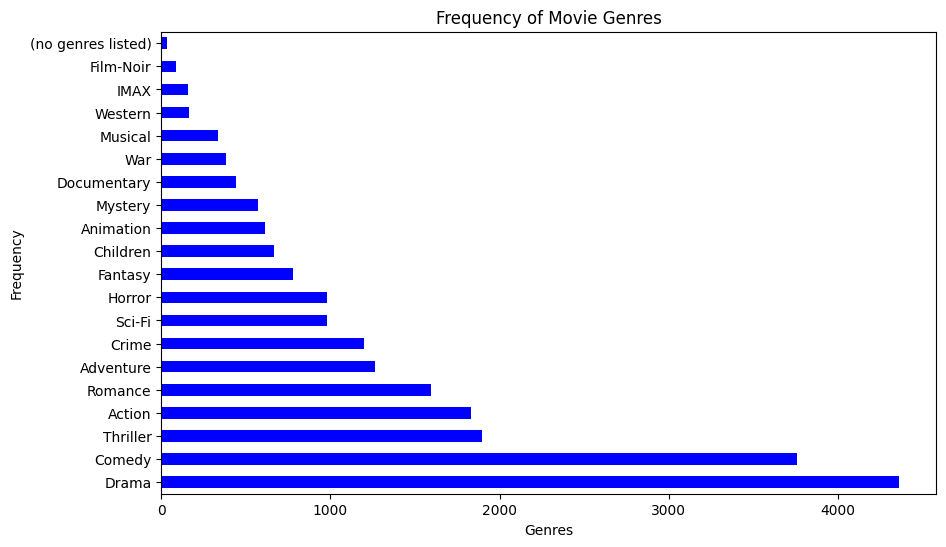

In [8]:
# Plot bar graph of genres
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='barh', color='blue')
plt.title('Frequency of Movie Genres')
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.show()

The bar graph visualizes the list of counts for each genre. This matches the information from the list as comedies and dramas are the two most frequent genres. 

### 2.3 Ratings Dataset

In [9]:
ratings = pd.read_csv('data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


The `.info()` method indicates that there are no null values in this dataset, which will simplify the data preparation stage. 

In [11]:
# prints the value_counts for each column in ratings


The `.value_counts()` output for the `ratings` dataframe shows the distribution of values in each feature, confirming no issues requiring attention during data preparation.

In [12]:
# prints the number of unique users and items in the ratings dataset
n_users = ratings.userId.nunique()
n_items = ratings.movieId.nunique()
print(f'The number of unique users is {n_users}')
print(f'The number of unique movies is {n_items}')

The number of unique users is 610
The number of unique movies is 9724


There are significantly more movies than users in this dataset, with **9724** unique movies compared to only **610** unique users. This imbalance may impact the choice of similarity measure during the modeling phase, as it will be important to determine whether to focus on user-user similarity or item-item similarity. This decision will be explored in more detail in Section 6: Modeling

In [13]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


The `.describe()` function provides descriptive statistics for each numeric feature in the dataset, offering a better understanding of the distribution of values. The movieId and userId are identifiers, making the most significant feature in this output the rating. From the summary, it is observed that the lowest rating is 0.5 and the highest is 5.0. This range of ratings is important because it will guide the approach to predicting movie ratings, ensuring that the recommendation system properly accounts for the full spectrum of user ratings

In [14]:
# stores the highest rating in the ratings dataset
max_rating = ratings.rating.max()

In [15]:
# stores the lowest rating in the ratings dataset
min_rating = ratings.rating.min()

In [16]:
ratings[['movieId', 'rating']].value_counts()

movieId  rating
318      5.0       153
296      5.0       123
356      5.0       116
2571     5.0       109
260      5.0       104
                  ... 
5096     1.5         1
         1.0         1
5095     4.5         1
5094     3.0         1
193609   4.0         1
Length: 30417, dtype: int64

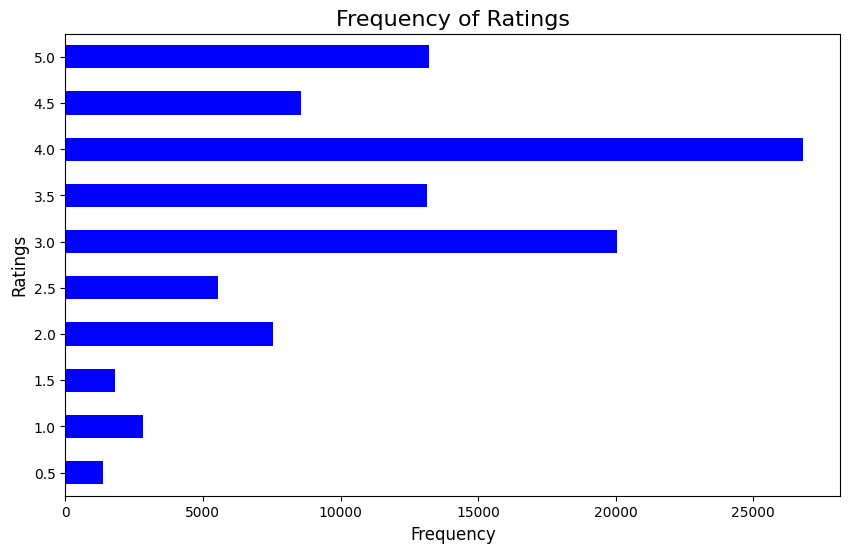

In [17]:
# Plots bar chart of ratings
plt.figure(figsize=(10, 6))
ratings.rating.value_counts().sort_index().plot(kind='barh', color='blue')

# Adds labels and title
plt.title('Frequency of Ratings', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Ratings', fontsize=12)

plt.show()

The bar chart visualizes the distribution of movie ratings on a 0.5–5.0 scale. The most frequent ratings are 4.0 and 3.0, which indicates that users tend to give ratings in the higher range more often.

## 3. <a name ="Data-Preparation"></a> Data Preparation

The `movies` and `ratings` dataframes were well-structured, requiring minimal data preparation. There were no issues with null values, incorrect datatypes, or the need to rename features, so the data preparation phase was relatively short. The main steps involved merging the two datasets using an inner join, which helped facilitate a more comprehensive Exploratory Data Analysis (EDA) by combining relevant information from both. Additionally, the `timestamp` feature was removed from the merged dataset, as it does not contribute to the functionality of the recommender system or the EDA.
Lastly, I dropped `timestamp` from `ratings` so `ratings` was prepared for use in the Surprise models. 

### 3.1 Joining `ratings` and `movies`

In [18]:
merged_df = pd.merge(ratings, movies, on='movieId', how='inner')
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [19]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


The output of `merged_df.info()` confirms that the join was successful, as the number of observations matches that of the original ratings dataset and there are no null values present. 

In [20]:
# Check for duplicates based on all columns
duplicate_rows = merged_df[merged_df.duplicated()]
duplicate_rows

,userId,movieId,rating,timestamp,title,genres


This output further confirms the join was successful as there are no duplicated rows in the merged dataframe. 

In [21]:
merged_df.drop(columns = 'timestamp', axis = 1, inplace = True)
merged_df

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...
100831,610,160341,2.5,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,Blair Witch (2016),Horror|Thriller


In [22]:
merged_df.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


### 3.2 Preparing `ratings` for Modeling with Surprise

In [23]:
cleaned_ratings = ratings.drop(columns = ['timestamp'], axis = 1)

The `cleaned_ratings` dataframe is created by dropping the `timestamp` column, as it is not needed for the recommendation system. This cleaned dataframe, containing only the relevant columns (`userId`, `movieId`, and `rating`), will be used for training the Surprise models.

In [24]:
cleaned_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## 4. <a name ="Exploratory-Data-Analysis"></a>Exploratory Data Analysis (EDA)

Key findings:
* There is a ***weak, positive*** correlation (**0.1273**) between a movie’s number of ratings and overall rating, indicating that popular movies tend to receive slightly higher ratings.
* The three most popular movies by number of reviews are *Forrest Gump*, *Shawshank Redemption*, and *Pulp Fiction*.
* By average rating, the *Film-Noir* genre is the highest rated (**3.92**), while *Horror* movies are the lowest rated (**3.28**).

The EDA phase was important for uncovering meaningful patterns and relationships in the dataset that directly informed the design of the recommendation system. For instance, understanding genre-specific trends provides additional insights into user preferences, helping refine the system to better align recommendations with individual tastes.

### 4.1 Relationship between Number of Ratings and Average Rating

In [25]:
# Groups by 'title' to calculate the number of reviews and average rating
movie_stats = merged_df.groupby('title').agg(
    num_reviews=('rating', 'count'),    # Count of reviews
    avg_rating=('rating', 'mean')       # Average rating
).reset_index()

# Sorts the table by number of reviews (descending), then by average rating (descending)
top_movies = movie_stats.sort_values(by=['num_reviews', 'avg_rating'], ascending=[False, False])

# Rounds the 'avg_rating' column to 2 decimal places
top_movies['avg_rating'] = top_movies['avg_rating'].round(2)

# Selects the top 20 movies
top_20_movies = top_movies.head(20)

top_20_movies

,title,num_reviews,avg_rating
3158,Forrest Gump (1994),329,4.16
7593,"Shawshank Redemption, The (1994)",317,4.43
6865,Pulp Fiction (1994),307,4.20
7680,"Silence of the Lambs, The (1991)",279,4.16
5512,"Matrix, The (1999)",278,4.19
8001,Star Wars: Episode IV - A New Hope (1977),251,4.23
4662,Jurassic Park (1993),238,3.75
1337,Braveheart (1995),237,4.03
8363,Terminator 2: Judgment Day (1991),224,3.97
7421,Schindler's List (1993),220,4.22


The table ranks the top 20 movies by the total number of ratings they have received, sorted in descending order. Additionally, each movie’s average rating is included. This helps provide an overview of whether movies with a high number of ratings also tend to have higher average ratings. This relationship will be further analyzed below.

In [26]:
# Calculates the correlation between number of reviews and average rating
correlation = movie_stats['num_reviews'].corr(movie_stats['avg_rating'])

round(correlation, 4)

0.1273

The output of **0.1273** indicates a **weak, positive** correlation between the number of reviews a movie receives and its average rating. This suggests that, to a small extent, movies with more reviews tend to have slightly higher average ratings.

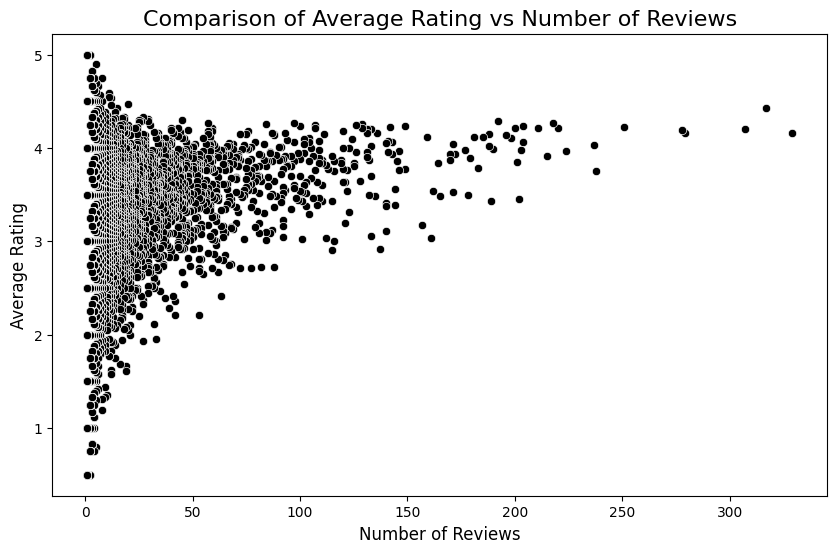

In [27]:
# Scatterplot comparing average rating and number of reviews
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(data=top_movies, x='num_reviews', y='avg_rating', color='black')

# Adds titles and labels
plt.title('Comparison of Average Rating vs Number of Reviews', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)

plt.show()

The scatterplot above visualizes the relationship between the number of reviews a movie receives and its average rating. The distribution of points shows a slight upward trend, indicating that movies with more reviews tend to have marginally higher average ratings. This observation aligns with the previously calculated correlation of **0.1273**, suggesting a **weak, positive** relationship.

### 4.2 Average Rating by Genre

In [28]:
# Splits the genres by '|'
merged_df['genres'] = merged_df['genres'].str.split('|')

# Expands the genres into separate rows, so each genre has its own row for each movie
merged_expanded = merged_df.explode('genres')

In [29]:
# Groups by genre and calculates the average rating for each genre
genres_avg_rating = merged_expanded.groupby('genres')['rating'].mean().reset_index()

# Sorts the table by average rating
genres_avg_rating_sorted = genres_avg_rating.sort_values(by='rating', ascending=False)

# Renames the 'rating' column to 'average rating'
genres_avg_rating_sorted = genres_avg_rating_sorted.rename(columns={'rating': 'average rating'})

# Rounds the 'average rating' column to 2 decimal places
genres_avg_rating_sorted['average rating'] = genres_avg_rating_sorted['average rating'].round(2)

genres_avg_rating_sorted

,genres,average rating
10,Film-Noir,3.92
18,War,3.81
7,Documentary,3.80
6,Crime,3.66
8,Drama,3.66
14,Mystery,3.63
3,Animation,3.63
12,IMAX,3.62
19,Western,3.58
13,Musical,3.56


The table displays the average rating for each movie genre. **Film-Noir** emerges as the highest-rated genre, with an average rating of **3.92**, while **Horror** is the lowest-rated, with an average rating of **3.26**.

This breakdown highlights the variation in audience reception across different genres and provides insights into genre-specific preferences

## 5. <a name ="Modeling"></a>  Modeling

The goal of the modeling phase was to train an effective model for a recommender system using the Surprise package, which is designed for building and implementing such systems.

For this project, I selected collaborative filtering (CF) over content-based filtering because collaborative filtering excels in identifying patterns in sparse matrices and scales more effectively. This scalability makes it better suited for Kanopy’s growing user base.

**Pipeline Development**

* I built a custom pipeline to streamline the modeling process. The pipeline processes datasets containing userId, movieId, and rating, splits them into an 80/20 train-test split, trains models, predicts ratings, and computes RMSE. RMSE, a standard metric in recommender systems, quantifies prediction errors as the distance between actual and predicted values. A smaller RMSE indicates better performance.

**Baseline Models**

* To establish benchmarks, I implemented two baseline models:
NormalPredictor (RMSE: 1.4212): Generates random predictions based on a normal distribution.
BaselineOnly (RMSE: 0.8637): Uses user and item biases for predictions.
These models provide a quick and robust reference for evaluating performance improvements.

**Advanced Models** 
1. Singular Value Decomposition (SVD)
    * RMSE: 0.8714
    * Chosen for its ability to efficiently handle sparse datasets, outperforming sklearn’s version.
2. KNNBasic
    * Implemented with cosine similarity (RMSE: 0.978) and Pearson correlation (RMSE: 0.974).
    * User-user filtering was applied due to the smaller number of users (601) compared to movies (9724), optimizing computational efficiency.

SVD outperformed KNNBasic, leading to its selection for hyperparameter tuning.

**Hyperparameter Tuning**

* SVD was optimized using `GridSearchCV` in two rounds, testing the parameters `n_factors`, `n_epochs`, `lr_all`, and `reg_all`. Three cross-folds were used to balance computational efficiency and robust evaluation, and RMSE was calculated for each iteration to assess improvements.

**Addressing the Cold Start Problem**

* A common issue for recommender systems, including Kanopy’s, is the cold start problem, as the platform does not collect user ratings. This can be particularly challenging for collaborative filtering systems due to the lack of user information. In Section 6: Evaluation, I outline a method to address this challenge.

### 5.1 Creating Modeling Pipeline with Surprise

In [30]:
class SurprisePipeline:
    """
    A pipeline for loading data, training a model, and evaluating its performance using the Surprise library.
    """
    def __init__(self, df, model=None, model_params=None, random_state=None):
        """
        Initializes the pipeline with the dataset, an optional model, and optional model parameters.
        
        Args:
            df (pandas.DataFrame): The DataFrame containing the ratings data, must include 'userId', 'movieId', and 'rating'.
            model (surprise.AlgoBase, optional): The model to be used for training and prediction (default is None).
            model_params (dict, optional): A dictionary of model hyperparameters (default is None).
            random_state (int, optional): The random seed for reproducibility (default is None).
        """
        self.df = df
        self.model = model
        self.model_params = model_params
        self.random_state = random_state
        self.trainset = None
        self.testset = None

    def load_data(self):
        """
        Loads the data into the Surprise format and splits it into training and testing sets.
        """
        reader = Reader(rating_scale=(0.5, 5))
        data = Dataset.load_from_df(self.df[['userId', 'movieId', 'rating']], reader)
        
        # Use random_state for reproducibility
        self.trainset, self.testset = train_test_split(data, test_size=0.2, random_state=self.random_state)
        return data

    def train(self):
        """
        Trains the specified model on the training dataset.
        """
        if not self.model:
            raise ValueError("Model is not defined. Please pass a valid model.")

        # If model parameters are provided, use them
        if self.model_params:
            self.model = self.model(**self.model_params)

        # Fits the model with the trainset
        self.model.fit(self.trainset)

    def evaluate(self):
        """
        Evaluates the trained model on the test dataset using RMSE.
        """
        if not self.model:
            raise ValueError("Model is not defined. Please pass a valid model.")
        
        # Makes predictions and evaluates the model
        predictions = self.model.test(self.testset)
        rmse = accuracy.rmse(predictions)
        return rmse

    def run(self):
        """
        Runs the entire pipeline: loads data, trains the model, and evaluates its performance.
        """
        # Loads data
        self.load_data()
        
        # Trains model
        self.train()
        
        # Evaluates model
        return self.evaluate()

#### Resources: 
https://stackoverflow.com/questions/43232506/using-pipeline-with-custom-classes-in-sklearn
https://medium.com/@mrnogues/building-a-general-purpose-pipeline-in-python-100-lines-of-code-428d6ff0d259
https://prappleizer.github.io/Tutorials/OOP/OOP_and_Classes.html

### 5.2 Baseline Models

#### 5.2.1 Baseline #1: Normal Predictor

In [31]:
# Model 1: NormalPredictor (Baseline1)
normal_predictor = NormalPredictor()
baseline1_norm_pred = SurprisePipeline(cleaned_ratings, model=normal_predictor, random_state = 42)
rmse_normal = baseline1_norm_pred.run()

RMSE: 1.4299


#### 5.2.2 Baseline #2: BaselineOnly

In [32]:
# Model 2: BaselineOnly (Baseline2)
baseline_only = BaselineOnly()
baseline2_baseline_only = SurprisePipeline(cleaned_ratings, model=baseline_only, random_state = 42)
rmse_baseline = baseline2_baseline_only.run()

Estimating biases using als...
RMSE: 0.8785


#### 5.2.3 Baseline Evaluation

The BaselineOnly model (RMSE = 0.8785) outperformed the NormalPredictor model (RMSE = 1.4281), establishing a solid benchmark for comparing my more advanced models.

### 5.3 Basic SVD Model

In [33]:
# Initializes SVD model
svd_basic = SVD()

# Creates a pipeline with the SVD model
pipeline_svd_basic = SurprisePipeline(cleaned_ratings, model=svd_basic, random_state = 42)

# Runs the pipeline
rmse_svd_basic = pipeline_svd_basic.run()

RMSE: 0.8826


### 5.3.1 Basic SVD Model Evaluation

The `svd_basic` model achieved an RMSE of 0.8823, which was slightly worse than the performance of the `BaselineOnly` model (RMSE: 0.8785). This result highlights the importance of careful model selection and optimization when applying collaborative filtering techniques.

SVD is a model-based collaborative filtering (CF) method that leverages matrix factorization to uncover latent features from sparse user-item rating data. While powerful in many cases, the basic implementation here underperformed, suggesting potential for improvement through tuning or alternative approaches.

### 5.4 Basic KNN Model

To explore other options, I test a memory/neighborhood-based collaborative filtering model next. These methods focus on user or item similarity to generate recommendations. Given the relatively small user base (601 users) compared to the number of items (9,724 movies) in this dataset, user-user filtering may be more computationally efficient, so I will use that.

The performance of the BasicKNN model will guide my decision on which advanced model to prioritize for hyperparameter tuning in subsequent steps.

In [34]:
print(f'The number of users is {n_users}')
print(f'The number of movies is {n_items}')

The number of users is 610
The number of movies is 9724


In [35]:
# Cosine similarity, user-based
sim_options_cosine = {
    'name': 'cosine',  # Similarity measure
    'user_based': True  # user-user similarity
}

# Pearson similarity, user-based
sim_options_pearson = {
    'name': 'pearson',  # Similarity measure
    'user_based': True  # user-user similarity
}

# Initializes the KNN model with Cosine similarity
knn_model_cosine = KNNBasic(sim_options=sim_options_cosine)

# Initializes the KNN model with Pearson similarity
knn_model_pearson = KNNBasic(sim_options=sim_options_pearson)

# Instantiates the pipeline with the DataFrame and the KNN model (Cosine)
pipeline_cosine = SurprisePipeline(cleaned_ratings, model=knn_model_cosine, random_state = 42)

# Instantiates the pipeline with the DataFrame and the KNN model (Pearson)
pipeline_pearson = SurprisePipeline(cleaned_ratings, model=knn_model_pearson, random_state = 42)

# Runs the pipeline with Cosine similarity
rmse_cosine = pipeline_cosine.run()

# Runs the pipeline with Pearson similarity
rmse_pearson = pipeline_pearson.run()

# Prints the RMSE for each model
print('-'*32)
print("RMSE with Cosine Similarity:", rmse_cosine)
print("RMSE with Pearson Similarity:", rmse_pearson)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9823
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9829
--------------------------------
RMSE with Cosine Similarity: 0.9822558142846856
RMSE with Pearson Similarity: 0.9829472991774267


#### 5.4.1 Basic KNN Model Evaluation

I experimented with two similarity metrics for the `KNNBasic` model: cosine and Pearson. Neither yielded particularly effective results, with RMSE scores of **0.9822** for cosine similarity and **0.9829** for Pearson similarity. This mediocre performance could be attributed to the sparsity of the dataset, which often limits the effectiveness of neighborhood-based approaches that rely on sufficient overlap between users or items for accurate similarity calculations.

**Next Steps**

Among the advanced models tested, I will move forward with hyperparameter tuning for SVD. This decision reflects a preference for a model-based approach for Kanopy’s recommender system. Not only did SVD outperform KNNBasic with a lower RMSE score, but model-based algorithms are generally better suited for scalability. As Kanopy’s user base and ratings database expand, SVD’s ability to handle sparse and large datasets makes it a more practical choice for the platform’s long-term needs.

### 5.5 SVD Tuning #1

I optimized the following parameters in `GridSearchCV`:

* **n_factors**: The number of latent factors in the model. This parameter controls the complexity of the model by defining how many features the algorithm will use to represent users and items. A higher value increases the model’s capacity to capture nuanced patterns but may also lead to overfitting.
* **n_epochs**: The number of iterations the algorithm runs during training. Each epoch represents a complete pass through the training data. Increasing this value allows the model to learn better by refining predictions over more cycles but may result in longer training times.
* **lr_all**: The learning rate for gradient descent. This parameter determines the step size for updating model parameters during optimization. A smaller learning rate ensures more stable convergence but may require more epochs, while a larger learning rate speeds up training but risks overshooting the optimal solution.
* **reg_all**: The regularization term to prevent overfitting. Regularization penalizes overly complex models by discouraging extreme parameter values. Balancing regularization is critical to ensure the model generalizes well to unseen data without underfitting.
    
I limited the search to a maximum of three values for the hyperparameters to balance computational efficiency with thorough exploration.

For the `GridSearchCV`, I used cv=3, which represents 3-fold cross-validation. This choice was intentional to balance computational efficiency with a thorough evaluation of model performance. By splitting the training data into three subsets, the model is trained and validated three times, allowing for a more robust estimation of performance without requiring excessive computational resources

In [36]:
#param_grid = {
    # Number of latent factors (dimensions)
 #   'n_factors': [20, 50, 100],
    
    # Number of iterations for training
 #   'n_epochs': [10, 20, 30], 
    
    # Learning rate for all parameters
 #   'lr_all': [0.005, 0.01],  
    
    # Regularization term
 #   'reg_all': [0.02, 0.1, 0.2]     
#}

In [37]:
# Performs GridSearchCV for tuning the SVD model
#grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, random_state = 42) 
#grid_search.fit(Dataset.load_from_df(cleaned_ratings[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5))))

In [38]:
# Gets the best parameters and the corresponding RMSE score
#best_params = grid_search.best_params['rmse']
#best_rmse = grid_search.best_score['rmse']

In [39]:
#best_params

In [40]:
#best_rmse

In [41]:
# saves the model

#with open('grid_search_SVD.pkl', 'wb') as f:
#    pickle.dump(grid_search, f)

In [42]:
# Loads the model
with open('grid_search_SVD.pkl', 'rb') as f:
    grid_search = pickle.load(f)

# Access the best parameters 
print(grid_search.best_params['rmse'])
print(grid_search.best_score['rmse'])

{'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}
0.8632005989159167


#### 5.5.1 SVD Tuning #1 Evaluation

### 5.6 SVD Tuning #2

In [43]:
#new_param_grid = {
    # Higher number of latent factors
 #   'n_factors': [150, 200],  
    
    # More training epochs
 #   'n_epochs': [20, 40, 50], 
    
    # Adjust learning rates
 #   'lr_all': [0.005, 0.02],  
    
    # Different regularization terms
 #   'reg_all': [0.1, 0.15, 0.3] 
#}

In [44]:
# Performs GridSearchCV for tuning SVD model
#grid_search2 = GridSearchCV(SVD, new_param_grid, measures=['rmse'], cv=3, random_state = 42) 
#grid_search2.fit(Dataset.load_from_df(cleaned_ratings[['userId', 'movieId', 'rating']], Reader(rating_scale=(0.5, 5))))

In [45]:
# Gets the best parameters and the corresponding RMSE score
#best_params2 = grid_search2.best_params['rmse']
#best_rmse2 = grid_search2.best_score['rmse']

In [46]:
#best_params2

In [47]:
#best_rmse2

In [48]:
# saves the model

#with open('grid_search2_SVD.pkl', 'wb') as f:
#    pickle.dump(grid_search2, f)

In [49]:
# Loads the model
with open('grid_search2_SVD.pkl', 'rb') as f:
    grid_search2 = pickle.load(f)

# Accesses the best parameters
print(grid_search2.best_params['rmse'])
print(grid_search2.best_score['rmse'])

{'n_factors': 150, 'n_epochs': 40, 'lr_all': 0.02, 'reg_all': 0.1}
0.8571339675493039


#### SVD Tuning #2 Evaluation

## 6. <a name ="Final-Model-Evaluation"></a> Final Model Evaluation

In this section, I trained my best-performing model, SVD, using optimized parameters. This model achieved an RMSE of **0.8559**. A table summarizing the models and their performance was created for clarity.

Next, I developed a series of functions for the recommender system, two of which are specifically designed to address the cold start problem. Detailed descriptions of these functions are provided below.

### 6.1 Best Model 

In [50]:
best_params = {
    'n_factors': 150,
    'n_epochs': 40,
    'lr_all': 0.02,
    'reg_all': 0.1
}

In [51]:
# defines and runs my best model
best_model = SurprisePipeline(df=cleaned_ratings, model=SVD, model_params=best_params, random_state = 42)

rmse_best_svd = best_model.run()

RMSE: 0.8572


In [52]:
# RMSE scores for the models
model_names = ['NormalPredictor', 'BaselineOnly', 'SVD_basic', 'KNNBasic (Cosine)', 'KNNBasic (Pearson)', 'SVD_GS1', 'SVD_GS2', 'SVD_best']
rmse_scores = [1.4239, 0.8785, 0.8808, 0.9823, 0.9829, 0.8632, 0.8571, 0.8559]

# Creates a DataFrame
df_models = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_scores
})

# Finds the index of the row with the minimum RMSE
min_rmse_idx = df_models['RMSE'].idxmin()

# Function that highlights the row with the lowest RMSE score
def highlight_best(row):
    return ['background-color: yellow' if row.name == min_rmse_idx else '' for _ in row]

# Applies the highlighting function to the DataFrame
styled_df = df_models.style.apply(highlight_best, axis=1)

styled_df

,Model,RMSE
0,NormalPredictor,1.423900
1,BaselineOnly,0.878500
2,SVD_basic,0.880800
3,KNNBasic (Cosine),0.982300
4,KNNBasic (Pearson),0.982900
5,SVD_GS1,0.863200
6,SVD_GS2,0.857100
7,SVD_best,0.855900


The table displays the models I trained along with their RMSE scores. The model with the lowest RMSE is highlighted in yellow, indicating the best-performing model for this project based on its accuracy in predicting outcomes.

### 6.2 <a name ="Recommendation-Functions"></a> Recommendation Functions

With the best model and tuned hyperparameters, I created 3 functions for this recommender system.
1. Basic Recommender (`basic_recommender()`): This function generates a list of the user’s top 5 recommended movies.


2.	Cold Start Recommender for New Users (`new_user_genre_recommend()`): This function builds on the `basic_recommender()` by asking users for their userID and preferred genre. Users then rate 5 random movies they’ve seen, and the function implements these ratings to provide a curated list of top 5 movie recommendations.


3.	Initial Ratings Collection Function (`user_rating_collection`): Specifically for the early stages of the system’s deployment, this function simply prompts users to rate 5 movies without offering recommendations. This helps Kanopy build its ratings database as it grows.

#### 6.2.1 Basic Recommender Function

In [53]:
def basic_recommender(user_id, model, df, movies_df, n=5):
    """
    Recommends the top n movies for a user based on a trained model.
    
    Args:
        user_id (int): The ID of the user for whom to recommend movies.
        model (surprise.AlgoBase): The trained model to use for generating predictions (e.g., SVD).
        df (pandas.DataFrame): The dataframe containing user ratings with 'userId', 'movieId', and 'rating' columns.
        movies_df (pandas.DataFrame): The dataframe containing movie metadata with 'movieId', 'title', and 'genres' columns.
        n (int): The number of top recommendations to return. Defaults to 5.
    
    Returns:
        list: A list of the top n movie recommendations, each as a tuple of (movieId, title, genres, predicted_rating).
    """
    # Gets all movie IDs
    all_movie_ids = set(movies_df['movieId'])

    # Gets the movie IDs the user has already rated
    rated_movie_ids = set(df[df['userId'] == user_id]['movieId'])

    # Gets the movie IDs the user hasn't rated
    unrated_movie_ids = list(all_movie_ids - rated_movie_ids)

    # Makes predictions for all unrated movies
    predictions = [model.predict(user_id, movie_id) for movie_id in unrated_movie_ids]

    # Sorts the predictions by the predicted rating (highest to lowest)
    sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)

    # Gets the top n recommended movie IDs
    top_n_movie_ids = [pred.iid for pred in sorted_predictions[:n]]

    # Gets the movie titles and genres for the top n recommended movie IDs
    top_movies = []
    for movie_id in top_n_movie_ids:
        # Check if the movie_id is valid 
        if movie_id in movies_df['movieId'].values:
            movie_info = movies_df[movies_df['movieId'] == movie_id].iloc[0]
            title = movie_info['title']
            genres = movie_info['genres']
            predicted_rating = [pred.est for pred in sorted_predictions if pred.iid == movie_id][0]
            top_movies.append((movie_id, title, genres, round(predicted_rating, 2)))
        else:
            # If the movie_id is not in the movies_df, skip it
            print(f"Warning: Movie ID {movie_id} not found in movie metadata.")

    # Print the top n recommendations
    for idx, (movie_id, title, genres, rating) in enumerate(top_movies, 1):
        print(f"Recommendation #{idx}: {title} (Genres: {genres}, Predicted Rating: {round(rating, 2)})")
        print(' '*32)

    return top_movies

### Resources:
https://www.freecodecamp.org/news/how-to-build-a-movie-recommendation-system-based-on-collaborative-filtering/

https://www.analyticsvidhya.com/blog/2020/11/create-your-own-movie-movie-recommendation-system/

In [54]:
# saves the first userID in a variable
min_user_id = ratings.userId.min()

# saves the last userID in a variable 
max_user_id = ratings.userId.max()

In [55]:
# Random user ID
user_id = random.randint(min_user_id, max_user_id)

# Recommends the top 5 movies for user_id using the trained model
basic_recommender(user_id, model=svd_basic, df=cleaned_ratings, movies_df=movies)

Recommendation #1: Life Is Beautiful (La Vita è bella) (1997) (Genres: Comedy|Drama|Romance|War, Predicted Rating: 4.52)
                                
Recommendation #2: Shining, The (1980) (Genres: Horror, Predicted Rating: 4.43)
                                
Recommendation #3: Forrest Gump (1994) (Genres: Comedy|Drama|Romance|War, Predicted Rating: 4.4)
                                
Recommendation #4: Evil Dead II (Dead by Dawn) (1987) (Genres: Action|Comedy|Fantasy|Horror, Predicted Rating: 4.4)
                                
Recommendation #5: Green Mile, The (1999) (Genres: Crime|Drama, Predicted Rating: 4.39)
                                


[(2324,
  'Life Is Beautiful (La Vita è bella) (1997)',
  'Comedy|Drama|Romance|War',
  4.52),
 (1258, 'Shining, The (1980)', 'Horror', 4.43),
 (356, 'Forrest Gump (1994)', 'Comedy|Drama|Romance|War', 4.4),
 (1261,
  'Evil Dead II (Dead by Dawn) (1987)',
  'Action|Comedy|Fantasy|Horror',
  4.4),
 (3147, 'Green Mile, The (1999)', 'Crime|Drama', 4.39)]

#### 6.2.2 Cold Start Solution: Recommender for New Users with Genre Preference

In [56]:
def new_user_genre_recommend(model, df, movies_df, n=5):
    
    """
    Recommends movies to a new user based on their genre preference and ratings for a subset of movies.
    
    This function guides a new user through a process where they:
    1. Provide their user ID.
    2. Choose a genre they like.
    3. Rate 5 movies within that genre.
    4. Based on the provided ratings, recommends other movies using the trained model.
    
    The function ensures that the user inputs are valid, and it updates the ratings dataframe
    with the new user's ratings before making movie recommendations.
    
    Parameters:
    model (object): A trained recommendation model used to predict movie ratings.
    df (pd.DataFrame): A dataframe containing historical ratings data with columns 'userId', 'movieId', and 'rating'.
    movies_df (pd.DataFrame): A dataframe containing movie information with columns 'movieId', 'title', and 'genres'.
    n (int, optional): The number of movie recommendations to return. Defaults to 5.
    
    Returns:
    None: This function prints out the top `n` recommended movies based on the user's ratings and genre preference.
    """
    
    # Asks the user to input their user ID
    while True:
        try:
            user_id = int(input("Please enter your user ID: "))
            if user_id <= 0:
                print("User ID must be a positive integer. Please try again.")
                continue
            break
        except ValueError:
            print("Invalid input. Please enter a valid integer for your user ID.")

    # Determines if the user is new or existing
    is_new_user = user_id not in df['userId'].unique()

    if is_new_user:
        print("It looks like you're a new user!")
        print("To provide better recommendations, we'll ask you to rate 5 movies.")

    # Asks for genre preference and validates the genre
    genre_input = ''
    while genre_input not in movies_df['genres'].str.split('|').explode().unique():
        genre_input = input("Enter a genre you like (e.g., 'Action', 'Comedy', 'Drama'): ").capitalize()
        if genre_input not in movies_df['genres'].str.split('|').explode().unique():
            print("Invalid genre. Please try again.")

    print(f"You've selected the genre: {genre_input}")

    # Filters movies by the selected genre
    genre_movies = movies_df[movies_df['genres'].str.contains(genre_input, case=False)]
    genre_movie_ids = genre_movies['movieId'].tolist()

    # Asks the user to rate 5 movies from the selected genre
    user_ratings = {}
    print(f"Please rate 5 movies from the {genre_input} genre (1-5), or type 'N/A' if you haven't seen the movie.")
    for movie_id in genre_movie_ids[:5]:
        movie_info = genre_movies[genre_movies['movieId'] == movie_id].iloc[0]
        movie_title = movie_info['title']
        while True:
            user_rating = input(f"Rate the movie '{movie_title}' (1-5) or 'N/A' if you haven't seen it: ")
            if user_rating.upper() == 'N/A':
                user_rating = None
                break
            try:
                # Allow float ratings
                user_rating = float(user_rating)
                if 1 <= user_rating <= 5:
                    break
                else:
                    print("Invalid rating. Please enter a number between 1 and 5 or 'N/A'.")
            except ValueError:
                print("Invalid input. Please enter a number between 1 and 5 or 'N/A'.")
        if user_rating is not None:
            user_ratings[movie_id] = user_rating

    # Updates the user’s ratings in the dataframe
    new_ratings_df = pd.DataFrame(user_ratings.items(), columns=['movieId', 'rating'])
    new_ratings_df['userId'] = user_id
    df_with_new_ratings = df.append(new_ratings_df, ignore_index=True)

    # Predicts and recommends movies for the user based on their ratings
    recommendations = []
    for movie_id in movies_df['movieId'].unique():
        # Avoid recommending movies the user has already rated
        if movie_id not in df_with_new_ratings[df_with_new_ratings['userId'] == user_id]['movieId'].values:
            prediction = model.predict(user_id, movie_id)
            recommendations.append((movie_id, prediction.est))

    # Sorts the recommendations by predicted rating
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:n]

    # Prints the recommendations
    print("\nHere are your top movie recommendations based on your ratings:")
    for i, (movie_id, predicted_rating) in enumerate(recommendations, 1):
        movie_title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
        print(f"Recommendation #{i}: {movie_title} (Predicted Rating: {predicted_rating:.2f})\n")

In [57]:
# testing out function
new_user_genre_recommend(model=svd_basic, df=cleaned_ratings, movies_df=movies, n=5)

Please enter your user ID: 
Invalid input. Please enter a valid integer for your user ID.
Please enter your user ID: 4
Enter a genre you like (e.g., 'Action', 'Comedy', 'Drama'): action
You've selected the genre: Action
Please rate 5 movies from the Action genre (1-5), or type 'N/A' if you haven't seen the movie.
Rate the movie 'Heat (1995)' (1-5) or 'N/A' if you haven't seen it: 3
Rate the movie 'Sudden Death (1995)' (1-5) or 'N/A' if you haven't seen it: 2
Rate the movie 'GoldenEye (1995)' (1-5) or 'N/A' if you haven't seen it: 4
Rate the movie 'Cutthroat Island (1995)' (1-5) or 'N/A' if you haven't seen it: 5
Rate the movie 'Money Train (1995)' (1-5) or 'N/A' if you haven't seen it: 2

Here are your top movie recommendations based on your ratings:
Recommendation #1: Cinema Paradiso (Nuovo cinema Paradiso) (1989) (Predicted Rating: 4.69)

Recommendation #2: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) (Predicted Rating: 4.61)

Recommendation #3: Lord of

In [59]:
new_user_genre_recommend(model=svd_basic, df=cleaned_ratings, movies_df=movies, n=5)

Please enter your user ID: 9999999
It looks like you're a new user!
To provide better recommendations, we'll ask you to rate 5 movies.
Enter a genre you like (e.g., 'Action', 'Comedy', 'Drama'): comedy
You've selected the genre: Comedy
Please rate 5 movies from the Comedy genre (1-5), or type 'N/A' if you haven't seen the movie.
Rate the movie 'Toy Story (1995)' (1-5) or 'N/A' if you haven't seen it: 5
Rate the movie 'Grumpier Old Men (1995)' (1-5) or 'N/A' if you haven't seen it: 3
Rate the movie 'Waiting to Exhale (1995)' (1-5) or 'N/A' if you haven't seen it: 4
Rate the movie 'Father of the Bride Part II (1995)' (1-5) or 'N/A' if you haven't seen it: 2
Rate the movie 'Sabrina (1995)' (1-5) or 'N/A' if you haven't seen it: 5

Here are your top movie recommendations based on your ratings:
Recommendation #1: Shawshank Redemption, The (1994) (Predicted Rating: 4.36)

Recommendation #2: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) (Predicted Rating: 4.35)



#### 6.2.3 Simple User Rating Function

In [60]:
def user_rating_collection(model, df, movies_df):
    
    """
    Prompts the user to input their user ID and rate 5 movies from a chosen genre.
    The function updates the dataset with the user's ratings but does not provide any movie recommendations.

    Parameters:
    model (object): The trained recommender model (not used in this function but needed for consistency).
    df (pandas.DataFrame): The DataFrame containing existing user ratings data.
    movies_df (pandas.DataFrame): The DataFrame containing movie information, including movie IDs, titles, and genres.

    Returns:
    None: This function updates the DataFrame with the user's ratings and does not return any values.

    Notes:
    - If the user is new (i.e., their user ID is not found in the existing ratings data), they are prompted with a special message.
    - The user is asked to rate 5 movies from a genre of their choice (or 'N/A' if they haven't seen a movie).
    - The ratings are added to the existing dataset for future use in recommendation generation.
    """
    
    # Asks the user to input their user ID
    while True:
        try:
            user_id = int(input("Please enter your user ID: "))
            if user_id <= 0:
                print("User ID must be a positive integer. Please try again.")
                continue
            break
        except ValueError:
            print("Invalid input. Please enter a valid integer for your user ID.")

    # Determines if the user is new or existing
    is_new_user = user_id not in df['userId'].unique()

    if is_new_user:
        print("It looks like you're a new user!")
        print("To provide better recommendations later, we'll ask you to rate 5 movies.")

    # Asks for genre preference and validates the genre
    genre_input = ''
    while genre_input not in movies_df['genres'].str.split('|').explode().unique():
        genre_input = input("Enter a genre you like (e.g., 'Action', 'Comedy', 'Drama'): ").capitalize()
        if genre_input not in movies_df['genres'].str.split('|').explode().unique():
            print("Invalid genre. Please try again.")

    print(f"You've selected the genre: {genre_input}")

    # Filters movies by the selected genre
    genre_movies = movies_df[movies_df['genres'].str.contains(genre_input, case=False)]
    genre_movie_ids = genre_movies['movieId'].tolist()

    # Asks the user to rate 5 movies from the selected genre
    user_ratings = {}
    print(f"Please rate 5 movies from the {genre_input} genre (1-5), or type 'N/A' if you haven't seen the movie.")
    for movie_id in genre_movie_ids[:5]:
        movie_info = genre_movies[genre_movies['movieId'] == movie_id].iloc[0]
        movie_title = movie_info['title']
        while True:
            user_rating = input(f"Rate the movie '{movie_title}' (1-5) or 'N/A' if you haven't seen it: ")
            if user_rating.upper() == 'N/A':
                user_rating = None
                break
            try:
                # Allow float ratings
                user_rating = float(user_rating)
                if 1 <= user_rating <= 5:
                    break
                else:
                    print("Invalid rating. Please enter a number between 1 and 5 or 'N/A'.")
            except ValueError:
                print("Invalid input. Please enter a number between 1 and 5 or 'N/A'.")
        if user_rating is not None:
            user_ratings[movie_id] = user_rating

    # Updates the user’s ratings in the dataframe
    
    new_ratings_df = pd.DataFrame(user_ratings.items(), columns=['movieId', 'rating'])
    new_ratings_df['userId'] = user_id
    df_with_new_ratings = df.append(new_ratings_df, ignore_index=True)

    print(f"Thank you! You've successfully rated 5 movies from the {genre_input} genre.")

In [61]:
user_rating_collection(model=svd_basic, df=cleaned_ratings, movies_df=movies)

Please enter your user ID: 1933384
It looks like you're a new user!
To provide better recommendations later, we'll ask you to rate 5 movies.
Enter a genre you like (e.g., 'Action', 'Comedy', 'Drama'): Drama
You've selected the genre: Drama
Please rate 5 movies from the Drama genre (1-5), or type 'N/A' if you haven't seen the movie.
Rate the movie 'Waiting to Exhale (1995)' (1-5) or 'N/A' if you haven't seen it: 5
Rate the movie 'American President, The (1995)' (1-5) or 'N/A' if you haven't seen it: 4
Rate the movie 'Nixon (1995)' (1-5) or 'N/A' if you haven't seen it: 5
Rate the movie 'Casino (1995)' (1-5) or 'N/A' if you haven't seen it: 4
Rate the movie 'Sense and Sensibility (1995)' (1-5) or 'N/A' if you haven't seen it: 2
Thank you! You've successfully rated 5 movies from the Drama genre.


## 7. <a name ="Conclusion"></a> Conclusion

### 7.1 <a name ="Limitations"></a> Limitations

While the approach used in this project is effective in many scenarios, there are several limitations that should be acknowledged:
1. **RMSE as an Evaluation Metric**:
* By using RMSE (Root Mean Square Error) as the evaluation metric, I treated this recommendation problem like a regression problem. However, this poses a limitation because the ratings data, ranging from 0.5 to 5.0, is ordinal in nature. Ordinal data represents categories with a defined order, but the numerical differences between these ratings do not necessarily reflect equal intervals. As a result, RMSE may not fully capture the nuances of ordinal data, where the distance between ratings such as 3 and 4 might not be the same as the distance between 4 and 5. Typically, ordinal data would be treated differently to avoid making assumptions about the spacing between ratings.
2. **Cold Start Problem**:
* A significant limitation in using collaborative filtering for recommendations is the cold start problem, which occurs when there is insufficient user data to make meaningful predictions. In the case of Kanopy, where users do not rate movies, this becomes a major issue. Collaborative filtering relies heavily on the ratings data from users to generate recommendations, and when new users or movies enter the system without sufficient ratings, it becomes difficult to make personalized recommendations. This is especially problematic in platforms like Kanopy that don’t actively collect user ratings.
3. **Time Limitations**:
* Building a comprehensive user rating database from scratch is a time-consuming process. Since the model relies on user ratings to generate recommendations, gathering enough ratings to make accurate predictions for all users and movies can take a significant amount of time. Without a substantial amount of user interaction, the model’s ability to make accurate and personalized recommendations will be limited, which could hinder its effectiveness during the early stages of deployment.

### 7.2 <a name ="Recommendations"></a> Recommendations

1.	**Begin Collecting User Ratings**
* Kanopy should begin by utilizing the simple user ratings function that was created in this project. This will allow users to rate movies they have watched, gradually building a robust ratings database. Collecting user ratings is crucial for feeding collaborative filtering algorithms and ensuring that the system can offer personalized recommendations over time.
2.	**Implement the Recommender System After Sufficient Data Collection**
* Once the ratings database has reached a sufficient size—perhaps after a few weeks of actively requesting ratings from users—the recommender system function can be implemented. This would allow Kanopy to start generating movie recommendations based on the collected ratings. With a larger database, the system can begin making more accurate predictions, enhancing the overall user experience.
3.	**Explore Additional Solutions to the Cold Start Problem**
* Given that Kanopy faces a cold start problem due to the lack of user ratings, it’s important to explore additional solutions. Potential approaches could include:
<br><br>
    * Content-based Filtering: In the absence of sufficient user ratings, a content-based filtering approach could be used, where movies are recommended based on their attributes (e.g., genre, director, cast) and a user’s preferences.
<br><br>    
    * Hybrid Models: Combining collaborative filtering with content-based filtering can mitigate the cold start problem. This hybrid approach can offer more relevant recommendations, especially for new users or movies with limited ratings.

### 7.3 <a name ="Next-Steps"></a> Next Steps

1. **Explore Additional Models within Surprise**
* SVD++: An enhanced version of SVD that incorporates implicit feedback, improving predictions with sparse ratings.

2.	**Address the Cold Start Problem with Clustering**
* K-Means Clustering: Cluster users or movies based on similarity to make recommendations for new users.
* HAC (Hierarchical Agglomerative Clustering): Group users or items hierarchically to recommend based on similar clusters.